# Imports and Functions

In [1]:
from datacube import Datacube
cdc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf', app = "Polygon drill")
from datacube_stats.statistics import GeoMedian
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.utils import geometry

import fiona
import rasterio.features
import geopandas as gpd

import numpy as np
import xarray as xr
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

#Import external dea-notebooks functions using relative link to Scripts directory
import sys
import os.path
sys.path.append('/g/data/u46/users/sc0554/dea-notebooks/Scripts')
import DEAPlotting

In [2]:
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import calendar


In [3]:

def animated_timeseries(ds, output_path, width_pixels=600, interval=100, bands=['red', 'green', 'blue'], 
                        reflect_stand=5000, title=False, show_date=True, onebandplot_cbar=True,
                        onebandplot_kwargs={}, annotation_kwargs={}):
    
    """
    Takes an xarray time series and animates the data as either a three-band (e.g. true or false colour) 
    or single-band animation, allowing changes in the landscape to be compared across time.
    
    Animations can be exported as .mp4 (ideal for Twitter/social media), .wmv (ideal for Powerpoint) and .gif 
    (ideal for all purposes, but can have large file sizes) format files, and customised to include titles and 
    date annotations or use specific combinations of input bands. 
    
    This function can be used to produce visually appealing cloud-free animations when used in combination with 
    the `load_clearlandsat` function from `dea-notebooks/Scripts/DEADataHandling`.
    
    Last modified: May 2018
    Author: Robbi Bishop-Taylor    
    
    :param ds: 
        An xarray dataset with multiple time steps (i.e. multiple observations along the `time` dimension).
        
    :param output_path: 
        A string giving the output location and filename of the resulting animation. File extensions of '.mp4', 
        '.wmv' and '.gif' are accepted.
    
    :param width_pixels:
        An integer defining the output width in pixels for the resulting animation. The height of the animation is
        set automatically based on the dimensions/ratio of the input xarray dataset. Defaults to 600 pixels wide.
        
    :param interval:
        An integer defining the milliseconds between each animation frame used to control the speed of the output
        animation. Higher values result in a slower animation. Defaults to 100 milliseconds between each frame. 
        
    :param bands:
        An optional list of either one or three bands to be plotted, all of which must exist in `ds`.
        Defaults to `['red', 'green', 'blue']`. 
        
    :param reflect_stand:
        An optional  integer controlling the brightness of the output image. Low values (< 5000) result in 
        brighter images. Defaults to 5000.

    :param title: 
        An optional string or list of strings with a length equal to the number of timesteps in ds. This can be
        used to display a static title (using a string), or a dynamic title (using a list) that displays different
        text for each timestep. Defaults to False, which plots no title.
        
    :param show_date:
        An optional boolean that defines whether or not to plot date annotations for each animation frame. Defaults 
        to True, which plots date annotations based on ds.
        
    :param onebandplot_cbar:
        An optional boolean indicating whether to include a colourbar for `ds1` one-band arrays. Defaults to True.
        
    :param onebandplot_kwargs:
        An optional dict of kwargs for controlling the appearance of one-band image arrays to pass to matplotlib 
        `plt.imshow` (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html for options).
        This only applies if an xarray with a single band is passed to `ds`. For example, a green colour scheme and
        custom stretch could be specified using: `onebandplot_kwargs={'cmap':'Greens`, 'vmin':0.2, 'vmax':0.9}`. 
        By default, one-band arrays are plotted using the 'Greys' cmap with a vmin of 0.0 and a vmax of 1.0.
    
    :param annotation_kwargs:
        An optional dict of kwargs for controlling the appearance of text annotations to pass to the matplotlib 
        `plt.annotate` function (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html for options). 
        For example, `annotation_kwargs={'fontsize':20, 'color':'red', 'family':'serif'}. By default, text annotations 
        are plotted as white, size 25 mono-spaced font with a 4pt black outline in the top-right of the animation.   
    """

    # Define function to convert xarray dataset to list of three band numpy arrays
    def _ds_to_arrraylist(ds, bands, reflect_stand):   

        array_list = []
        for i, timestep in enumerate(ds.time):

            # Select single timestep from the data array
            ds_i = ds.isel(time = i)

            # Create new three band array
            y, x = ds_i[bands[0]].shape

            if len(bands) == 1:    

                # Create new three band array
                img_toshow = ds_i[bands[0]].values

            else:

                rawimg = np.zeros((y, x, 3), dtype=np.float32)

                # Add xarray bands into three dimensional numpy array
                for band, colour in enumerate(bands):

                    rawimg[:, :, band] = ds_i[colour].values

                # Stretch contrast using defined reflectance standardisation; defaults to 5000
                img_toshow = (rawimg / reflect_stand).clip(0, 1)

            array_list.append(img_toshow)

        return(array_list)
    
    
    def _add_colourbar(ax, im, vmin, vmax, fontsize):
        
        """
        Add a nicely formatted colourbar to an animation panel
        """

        # Add underlying bar
        cbbox = inset_axes(ax, '100%', '7%', loc = 8, borderpad=0)
        [cbbox.spines[k].set_visible(False) for k in cbbox.spines]
        cbbox.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                          labelleft=False, labeltop=False, labelright=False, labelbottom=False)
        cbbox.set_facecolor([0, 0, 0, 0.4])

        # Add colourbar
        axins2 = inset_axes(ax, width="90%", height="3%", loc=8) 
        fig.colorbar(im, cax=axins2, orientation="horizontal", ticks=np.linspace(vmin, vmax, 3)) 
        axins2.xaxis.set_ticks_position("top")
        axins2.tick_params(axis='x', colors='white', labelsize=fontsize, pad=1, length=0)
        axins2.get_xticklabels()[0].set_horizontalalignment('left')
        axins2.get_xticklabels()[-1].set_horizontalalignment('right') 
        
    
    ###############
    # Setup steps #
    ############### 
    
    # Get number of timesteps for each dataset
    timesteps = len(ds.time)
    
    # If title is supplied as a string, multiply out to a list with one string per timestep.
    # Otherwise, use supplied list for plot titles.
    if isinstance(title, str) or isinstance(title, bool):
        title_list = [title] * timesteps 
    else:
        title_list = title
    
    # Set up annotation parameters that plt.imshow plotting for single band array images. 
    # The nested dict structure sets default values which can be overwritten/customised by the 
    # manually specified `onebandplot_kwargs`
    onebandplot_kwargs = dict({'cmap':'Greys', 'vmin':0.0, 'vmax':1.0, 'interpolation':'bilinear'},
                               **onebandplot_kwargs)         
    
    # Set up annotation parameters that control font etc. The nested dict structure sets default 
    # values which can be overwritten/customised by the manually specified `annotation_kwargs`
    annotation_kwargs = dict({'xy': (1, 1), 'xycoords':'axes fraction', 
                              'xytext':(-5, -5), 'textcoords':'offset points', 
                              'horizontalalignment':'right', 'verticalalignment':'top', 
                              'fontsize':25, 'color':'white', 'family':'monospace', 
                              'path_effects':[PathEffects.withStroke(linewidth=4, foreground='black')]},
                              **annotation_kwargs)
   
    
    ###################
    # Initialise plot #
    ################### 
    
    # First test if there are three bands, and that all exist in both datasets:
    if ((len(bands) == 3) | (len(bands) == 1)) & all([(b in ds.data_vars) for b in bands]): 
        
        # Get height relative to a size of 10 inches width
        width_ratio = float(ds.sizes['x']) / float(ds.sizes['y'])
        height = 10.0 / width_ratio

        # Import xarrays as lists of three band numpy arrays
        imagelist = _ds_to_arrraylist(ds, bands=bands, reflect_stand=reflect_stand)        

        # Set up figure
        fig, ax1 = plt.subplots(ncols=1) 
        fig.patch.set_facecolor('black')
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        fig.set_size_inches(10.0, height, forward=True)
        ax1.axis('off')

        # Initialise axesimage objects to be updated during animation
        extents = [float(ds.x.min()), float(ds.x.max()), 
          float(ds.y.min()), float(ds.y.max())]
        
        im = ax1.imshow(imagelist[0], **onebandplot_kwargs, extent=extents)
        
        # add shapefile
        shapefile_overlay = gpd.read_file("/g/data/u46/users/ext547/ewater/input_data/Cambodia_boundary/KHM_adm0.shp")
        shapefile_overlay.plot(ax = ax1, linewidth=2, edgecolor='black', facecolor="#00000000")

        # Initialise annotation objects to be updated during animation
        t = ax1.annotate('', **annotation_kwargs)
        
        # Optionally add colourbar for one band images
        if (len(bands) == 1) & onebandplot_cbar:                
            _add_colourbar(ax1, im, fontsize=20,
                           vmin=onebandplot_kwargs['vmin'], 
                           vmax=onebandplot_kwargs['vmax'])

        # Function to update figure
        def update_figure(frame_i):

            ####################
            # Plot first panel #
            ####################  

            # Get human-readable date info (e.g. "16 May 1990")
            ts = ds.time.isel(time=frame_i).dt
            year = ts.year.item()
            month = ts.month.item()
            day = ts.day.item()

            # Create annotation string based on title and date specifications:
            title = title_list[frame_i]
            if title and show_date:
                title_date = '{} {} {}\n{}'.format(day, calendar.month_abbr[month], year, title)
            elif title and not show_date:
                title_date = '{}'.format(title)
            elif show_date and not title:
                title_date = '{} {} {}'.format(day, calendar.month_abbr[month], year)           
            else:
                title_date = ''

            # Update figure for frame
            im.set_array(imagelist[frame_i])
            t.set_text(title_date) 

            # Return the artists set
            return [im, t]


        ##############################
        # Generate and run animation #
        ##############################

        # Generate animation
        print('Generating {} frame animation'.format(timesteps))
        ani = animation.FuncAnimation(fig, update_figure, frames=timesteps, interval=interval, blit=True)

        # Export as either MP4 or GIF
        if output_path[-3:] == 'mp4':
            print('    Exporting animation to {}'.format(output_path))
            ani.save(output_path, dpi=width_pixels / 10.0)

        elif output_path[-3:] == 'wmv':
            print('    Exporting animation to {}'.format(output_path))
            ani.save(output_path, dpi=width_pixels / 10.0, 
                     writer=animation.FFMpegFileWriter(fps=1000 / interval, bitrate=4000, codec='wmv2'))

        elif output_path[-3:] == 'gif':
            print('    Exporting animation to {}'.format(output_path))
            ani.save(output_path, dpi=width_pixels / 10.0, writer='imagemagick')

        else:
            print('    Output file type must be either .mp4, .wmv or .gif')

    else:        
        print('Please select either one or three bands that all exist in the input dataset')  




In [4]:
#Define function to either read or load environmental data from Cambodia Cube
def LoadAreaOfInterest(study_area):
    '''
    Firstly, LoadAreaOfInterest checks whether a pickle, that contains an xarray of nbar data, 
    is saved in the output folder. If there is no pickle, the function searches the 
    "AreaOfInterest" function to gain lat/lon information for that particular study_area. If 
    there is no lat/lon coordinates in the AreaOfInterest function, then an error is returned. 
    If the coordinates are found, nbar data is loaded and masked. Finally data from all 
    sensors are concatenated together into one xarray.
   
    Last modified: March 2018
    
    Author: Erin Telfer
    
    Inputs: 
    study_area - the name of the study area
    '''
    
    study_area=study_area.lower().replace(" ","")
    lat_min, lat_max, lon_min, lon_max = AreaOfInterest(study_area)
            
    print("Loading Cambodia Cube data")
    dataset = {}

    #query is created
    query = {'time': (start_of_epoch, end_of_epoch),}
    query['x'] = (lon_min, lon_max)
    query['y'] = (lat_max, lat_min)
    query['crs'] = 'EPSG:4326'
    query['resolution'] = (-0.5,0.5)

    print(query)

    for item in list_of_products: #loop through specified
        environmental_variable = cdc.load(product= item, group_by='solar_day', **query)
        #retrieve the projection information
        crs = environmental_variable.crs
        crswkt = environmental_variable.crs.wkt
        affine = environmental_variable.affine
        dataset[item] = environmental_variable

        print('loaded %s' % item) 
    print('ls load complete')


    #data from different sensors are joined together and sorted so that observations are sorted by time rather than sensor
    environmental_variable = xr.concat(dataset.values(), 'time')
    environmental_variable = environmental_variable.sortby('time')
    environmental_variable.attrs['crs'] = crs
    environmental_variable.attrs['affin|e'] = affine          
                    
    #print("saving data as {0}.pkl".format(study_area))

    #pickle.dump(nbar_clean, open(pickle_location,"wb")) #save nbar as pickle
    return environmental_variable

In [5]:
#Define function to define the coordinates for the study area#Define 
def AreaOfInterest(study_area):
    if study_area == 'phumsrahkaev':
        lat_min = 13.000 #down
        lat_max = 13.100 #up
        lon_min = 103.300 #left
        lon_max = 103.400 #right  
    elif study_area == 'outapaong':
        lat_min = 12.600 #down
        lat_max = 12.800 #up
        lon_min = 103.600 #left
        lon_max = 103.800 #right
    elif study_area == 'mondulkiri':
        lat_min = 12.863 #down
        lat_max = 13.663 #up
        lon_min = 106.350 #left
        lon_max = 107.236 #right
    elif study_area == 'krongstungtreng':
        lat_min = 13.181 #down
        lat_max = 13.681 #up
        lon_min = 105.781 #left
        lon_max = 106.381 #right
    elif study_area == 'kaohnheaek':
        lat_min = 13.000 #down
        lat_max = 13.100 #up
        lon_min = 107.000 #left
        lon_max = 107.100 #right
    elif study_area == 'neakleoang':
        lat_min = 11.246 #down
        lat_max = 11.532 #up
        lon_min = 105.141 #left
        lon_max = 105.380 #right
    elif study_area == 'tonlesaplake':
        lat_min = 13.020 #down
        lat_max = 13.120 #up
        lon_min = 103.740 #left
        lon_max = 103.840 #right
    elif study_area == 'maximum_extent':
        lat_min = 9.25 #down
        lat_max = 15.25 #up
        lon_min = 101.75 #left
        lon_max = 108.25 #right     
    else:
        print('FileNotFoundError')
    return (lat_min, lat_max, lon_min, lon_max)



In [6]:
def write_your_netcdf(data, dataset_name, filename, crs):

    """
    This function turns an xarray dataarray into a dataset so we can write it to netcdf. 
    It adds on a crs definition from the original array. data = your xarray dataset, dataset_name 
    is a string describing your variable
    
    Last modified: May 2018
    Author: Bex Dunn    
    """ 
   
    #turn array into dataset so we can write the netcdf
    if isinstance(data,xr.DataArray):
        dataset= data.to_dataset(name=dataset_name)
    elif isinstance(data,xr.Dataset):
        dataset = data
    else:
        print('your data might be the wrong type, it is: '+type(data))
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs

    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))    

In [7]:
#Define function to create subplots of all scenes within an array as subplots
def one_band_image_subplots(ds, num_cols, figsize = [10,40], left  = 0.125, 
                              right = 0.9, bottom = 0.1, top = 0.9, 
                              wspace = 0.2, hspace = 0.4):
    '''
    one_band_image_subplots takes a dataset with one band and multiple time steps, 
    and plots them in image. 
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause and Erin Telfer
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    num_cols - number of columns for the subplot
    
    Optional:
    figsize - dimensions for the output figure
    left  - the space on the left side of the subplots of the figure
    right - the space on the right side of the subplots of the figure
    bottom - the space on the bottom of the subplots of the figure
    top - the space on the top of the subplots of the figure
    wspace - the amount of width reserved for blank space between subplots
    hspace - the amount of height reserved for white space between subplots
    '''
    # Find the number of rows/columns we need, based on the number of time steps in ds
    fig = plt.figure(figsize = figsize)
    timesteps = ds.time.size
    num_rows = int(np.ceil(timesteps/num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    fig.subplots_adjust(left  = left, right = right, bottom = bottom, top = top, 
                        wspace = wspace, hspace = hspace)
    try: #loop through all scenes, prepare imagery and create subplots
        for i, ax in enumerate(fig.axes):
            image_ds = ds.rainfall.isel(time =i)
            ax.set_title(str(image_ds.time.values)[0:10])
            ax.imshow(image_ds, interpolation = 'nearest') #plot image as subplot
    except IndexError: #if there are an odd number of plots, this code will allow plotting of images
        fig.delaxes(ax)
        plt.draw() 

# Datacube query and pre-processing

In [8]:
#define study area
study_area = 'maximum_extent' #name of study area
#study_area=study_area.lower().replace(" ","") #reformat to remove uppercase and spaces

#define temporal range ()
start_of_epoch = '1998-01-01'
end_of_epoch =  '2016-12-01'

#specify output folder
output_folder= '/g/data/u46/users/sc0554/climate_indices_input/'

** Load the PET and Rainfall data from datacube **

In [9]:
# load the PET and Rainfall from the datacube
list_of_products = ['rainfall_grids_1998_2017']
rainfall=LoadAreaOfInterest(study_area)
print(rainfall.rainfall)
list_of_products = ['pet_grids_1979_2016']
pet=LoadAreaOfInterest(study_area)
pet = pet.rename({'PET': 'pet'})
print(pet.pet)

Loading Cambodia Cube data
{'time': ('1998-01-01', '2016-12-01'), 'x': (101.75, 108.25), 'y': (15.25, 9.25), 'crs': 'EPSG:4326', 'resolution': (-0.5, 0.5)}
loaded rainfall_grids_1998_2017
ls load complete
<xarray.DataArray 'rainfall' (time: 6910, latitude: 13, longitude: 14)>
array([[[ 0.0000e+00,  0.0000e+00, ...,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, ...,  0.0000e+00,  0.0000e+00],
        ...,
        [ 3.0000e-01,  1.5600e+00, ..., -9.9999e+03,  0.0000e+00],
        [ 3.0000e-01,  0.0000e+00, ..., -9.9999e+03,  0.0000e+00]],

       [[ 0.0000e+00,  0.0000e+00, ...,  0.0000e+00, -9.9999e+03],
        [ 0.0000e+00,  0.0000e+00, ...,  0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00, ...,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, ...,  0.0000e+00,  0.0000e+00]],

       ...,

       [[ 0.0000e+00,  0.0000e+00, ...,  9.0000e+00,  2.4030e+01],
        [ 0.0000e+00,  0.0000e+00, ...,  1.4280e+01,  3.3660e+01],
        ..

**Mask datacube using shapefile of Cambodia**

In [10]:
shape_file = os.path.expanduser("/g/data/u46/users/ext547/ewater/input_data/Cambodia_boundary/KHM_adm0.shp")
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

In [30]:
rainfall_mask = rasterio.features.geometry_mask([geom.to_crs(rainfall.geobox.crs) for geoms in [geom]],
                                           out_shape=rainfall.geobox.shape,
                                           transform=rainfall.geobox.affine,
                                           all_touched=True,
                                           invert=True)
pet_mask = rasterio.features.geometry_mask([geom.to_crs(pet.geobox.crs) for geoms in [geom]],
                                           out_shape=pet.geobox.shape,
                                           transform=pet.geobox.affine,
                                           all_touched=True,
                                           invert=True)

rainfall_masked = rainfall.where(rainfall_mask)
pet_masked = pet.where(pet_mask)

**Plot an example date for queried data**

In [ ]:
# exampledataprcp = xr.open_dataset('/g/data/u46/users/sc0554/climate_indices/example_inputs/nclimgrid_lowres_prcp.nc')
# exampledatapet = xr.open_dataset('/g/data/u46/users/sc0554/climate_indices/example_inputs/nclimgrid_lowres_pet.nc')

In [ ]:
# print(exampledataprcp.prcp)
# print(exampledatapet.pet)

In [37]:
environmental_data = {'rainfall': rainfall, 'pet':pet}
monthly_environmental_data = {}
#resample to monthly averages and assign spatial and time units
for key, data in environmental_data.items():
    print (key)
    data[key].values[data[key].values == -9999.9] = np.nan
    #sum the total amount for the month
    data = data.resample(time = 'm').sum()
    data.attrs['crs'] = environmental_data[key].crs
    data.attrs['affin|e'] =environmental_data[key].attrs['affin|e']
    data.time.attrs['units'] = environmental_data[key].time.units #'seconds since 1970-01-01 00:00:00'
    data[key].attrs['units'] = 'millimeter'
    data = data.transpose('latitude', 'longitude', 'time')
    monthly_environmental_data[key] = data

environmental_data_masked = {'rainfall': rainfall_masked, 'pet':pet_masked}
monthly_environmental_data_masked = {}
#resample to monthly averages and assign spatial and time units
for key, data in environmental_data_masked.items():
    print (key)
    data[key].values[data[key].values == -9999.9] = np.nan
    #sum the total amount for the month
    data = data.resample(time = 'm').sum()
    data.attrs['crs'] = environmental_data_masked[key].crs
    data.attrs['affin|e'] =environmental_data_masked[key].attrs['affin|e']
    data.time.attrs['units'] = environmental_data_masked[key].time.units #'seconds since 1970-01-01 00:00:00'
    data[key].attrs['units'] = 'millimeter'
    data = data.transpose('latitude', 'longitude', 'time')
    monthly_environmental_data_masked[key] = data

rainfall
pet
rainfall
pet


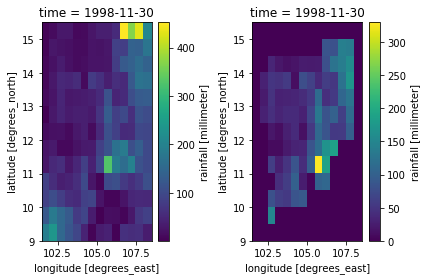

In [53]:
plt.subplot(121)
monthly_environmental_data['rainfall'].rainfall.isel(time = 10).plot()
plt.subplot(122)
monthly_environmental_data_masked['rainfall'].rainfall.isel(time = 10).plot()

plt.tight_layout()
plt.show()


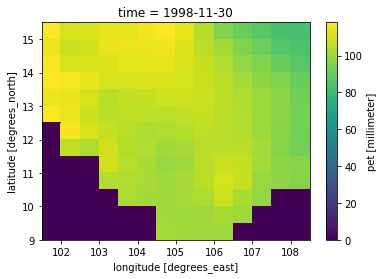

In [34]:
monthly_environmental_data['pet'].pet.isel(time = 10).plot()

In [ ]:
fig = plt.figure(figsize=(11,7))
monthly_environmental_data['rainfall'].rainfall.mean(dim = ['latitude', 'longitude']).plot()

In [ ]:
fig = plt.figure(figsize=(11,7))
rainfallmasked.rainfall.mean(dim = ['latitude', 'longitude']).plot()

In [ ]:
fig = plt.figure(figsize=(11,7))
petmasked.pet.mean(dim = ['latitude', 'longitude']).plot()

In [ ]:
fig = plt.figure(figsize=(11,7))
monthly_environmental_data['pet'].pet.mean(dim = ['latitude', 'longitude']).plot()

### Save out input data as NETCDF

In [68]:
for key, data in monthly_environmental_data.items():
    write_your_netcdf(data = data, dataset_name = key, filename = '/g/data/u46/users/sc0554/climate_indices_input/{0}_cambodia_1998_2016_monthly.nc'.format(key), crs = data.crs)
#SPEI_input_grouped.to_netcdf(path = '/g/data/u46/users/sc0554/climate_indices_input/rainfalltest98_16.nc', format = 'NETCDF4')

### Calculate SPEI using climate_indices module and plot / animate results

In [70]:
! /g/data/u46/users/sc0554/call_climate_indices.sh --index spei --periodicity monthly --netcdf_precip /g/data/u46/users/sc0554/climate_indices_input/rainfall_cambodia_1998_2016_monthly_masked.nc --var_name_precip rainfall --netcdf_pet /g/data/u46/users/sc0554/climate_indices_input/pet_cambodia_1998_2016_monthly_masked.nc --output_file_base /g/data/u46/users/sc0554/climate_indices_output/cambodia_masked --var_name_pet pet --scales 3 --calibration_start_year 1998 --calibration_end_year 2016
! /g/data/u46/users/sc0554/call_climate_indices.sh --index spei --periodicity monthly --netcdf_precip /g/data/u46/users/sc0554/climate_indices_input/rainfall_cambodia_1998_2016_monthly_masked.nc --var_name_precip rainfall --netcdf_pet /g/data/u46/users/sc0554/climate_indices_input/pet_cambodia_1998_2016_monthly_masked.nc --output_file_base /g/data/u46/users/sc0554/climate_indices_output/cambodia_masked --var_name_pet pet --scales 12 --calibration_start_year 1998 --calibration_end_year 2016

Python 3.6.5 :: Anaconda, Inc.
Python 3.6.5
1.14.5
2018-07-19  17:28:24 INFO Start time:    2018-07-19 17:28:24.733761
2018-07-19  17:28:24 INFO Computing 3-month SPEI for latitude index 3
2018-07-19  17:28:24 INFO Computing 3-month SPEI for latitude index 0
2018-07-19  17:28:24 INFO Computing 3-month SPEI for latitude index 1
2018-07-19  17:28:24 INFO Computing 3-month SPEI for latitude index 2
2018-07-19  17:28:24 INFO Computing 3-month SPEI for latitude index 5
2018-07-19  17:28:24 INFO Computing 3-month SPEI for latitude index 4
2018-07-19  17:28:24 INFO Computing 3-month SPEI for latitude index 7
2018-07-19  17:28:24 INFO Computing 3-month SPEI for latitude index 6
2018-07-19  17:28:25 INFO Computing 3-month SPEI for latitude index 8
2018-07-19  17:28:25 INFO Computing 3-month SPEI for latitude index 9
2018-07-19  17:28:25 INFO Computing 3-month SPEI for latitude index 10
2018-07-19  17:28:25 INFO Computing 3-month SPEI for latitude index 11
2018-07-19  17:28:25 INFO Computing 3-m

**Read in modelled drought index data**

In [71]:
cambodia_spei_03 = xr.open_dataset('/g/data/u46/users/sc0554/climate_indices_output/cambodia_spei_gamma_03.nc')
cambodia_spei_03 = cambodia_spei_03.transpose('time', 'latitude', 'longitude')
# cambodia_spei_06 = xr.open_dataset('/g/data/u46/users/sc0554/climate_indices_output/cambodia_spei_gamma_06.nc')
# cambodia_spei_06 = cambodia_spei_06.transpose('time', 'latitude', 'longitude')
cambodia_spei_12 = xr.open_dataset('/g/data/u46/users/sc0554/climate_indices_output/cambodia_spei_gamma_12.nc')
cambodia_spei_12 = cambodia_spei_12.transpose('time', 'latitude', 'longitude')

In [58]:
cambodia_spei_03.to_netcdf(path = '/g/data/u46/users/sc0554/climate_indices_output/cambodia_monthly_spei_gamma_03_transform.nc', format = 'NETCDF4')
cambodia_spei_12.to_netcdf(path = '/g/data/u46/users/sc0554/climate_indices_output/cambodia_monthly_spei_gamma_12_transform.nc', format = 'NETCDF4')

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


**Resample to Seasonal mean**

In [ ]:
# cambodia_spei_03_seasonal = cambodia_spei_03.resample(time="Q-DEC").mean()

**Plot each image at each time step**

In [ ]:
fig, axes = plt.subplots(100, 3, sharex='col', sharey='row', figsize = (12, 500))
for i in range(100):
    spei_plot = axes[i][0].imshow(cambodia_spei_03.spei_gamma_03.isel(time=i).values)
    plt.colorbar(spei_plot)
    axes[i][1].imshow(monthly_environmental_data['rainfall'].rainfall.isel(time=i).values)
    axes[i][2].imshow(monthly_environmental_data['pet'].pet.isel(time=i).values)
plt.tight_layout()
plt.show()

In [ ]:
# spei_03_seasonal_plot = cambodia_spei_03_seasonal.spei_gamma_03.plot(x='longitude', y = 'latitude', col='time', col_wrap=3)
# spei_06_seasonal_plot = cambodia_spei_06_seasonal.spei_gamma_06.plot(x='longitude', y = 'latitude', col='time', col_wrap=3)
# spei_12_seasonal_plot = cambodia_spei_12_seasonal.spei_gamma_12.plot(x='longitude', y = 'latitude', col='time', col_wrap=3)

**Mean (spatial) SPEI plotting**


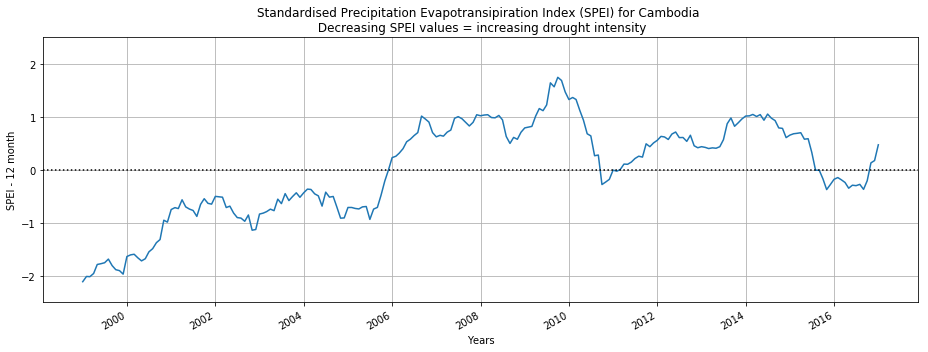

In [61]:
#Comparison plot of mean SPEI for Cambodia over time at monthly interval for 3 different SPEI time scales
fig, ax1 = plt.subplots(figsize=(13,5))
cambodia_spei_12.spei_gamma_12.mean(dim = ['latitude', 'longitude']).plot()
#ambodia_spei_06.spei_gamma_06.mean(dim = ['latitude', 'longitude']).plot()
# cambodia_spei_12.spei_gamma_12.mean(dim = ['latitude', 'longitude']).plot()
plt.xlabel('Years')
plt.ylabel('SPEI - 12 month')
#plt.legend()
plt.title('Standardised Precipitation Evapotransipiration Index (SPEI) for Cambodia \n Decreasing SPEI values = increasing drought intensity')
plt.grid()
ax1.set_ylim(-2.5, 2.5)
ax1.axhline(y=0, color ='k', linestyle = 'dotted')
plt.tight_layout()
fig.savefig('SPEI_12_masked.jpg')

In [ ]:
#Comparison plot of mean SPEI for Cambodia over time at seasonal interval 
# fig = plt.figure(figsize =(11, 7))
# plot1, = cambodia_spei_03.spei_gamma_03.mean(dim = ['latitude', 'longitude']).plot()
# plot2, = cambodia_spei_03_seasonal.spei_gamma_03.mean(dim = ['latitude', 'longitude']).plot()
# plt.legend((plot1, plot2), ('monthly', 'seasonal'))
# plt.title('SPEI_03 seasonal vs monthly comparison')
# plt.tight_layout()
# fig.savefig('SPEI_03_monthly_seasonal_comparison.jpg')

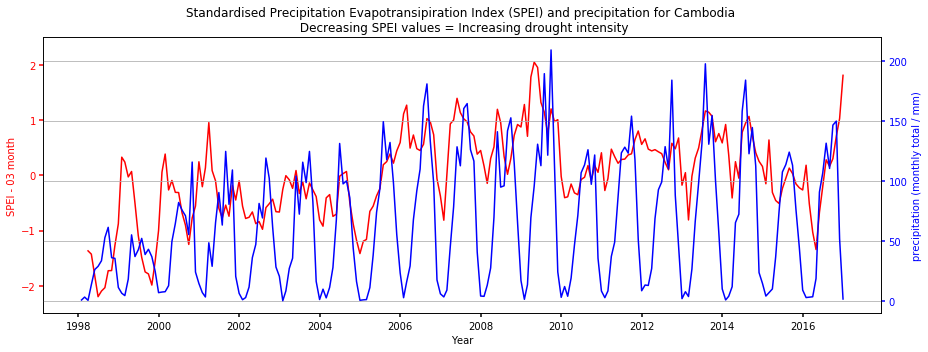

In [64]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax1 = plt.subplots(figsize=(13,5))
fig.subplots_adjust(right=0.75)

speiplot, = ax1.plot(cambodia_spei_03.time, cambodia_spei_03.spei_gamma_03.mean(dim = ['latitude', 'longitude']), 'r-')
ax1.set_xlabel('Year')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('SPEI - 03 month')

ax2 = ax1.twinx()
rainfallplot, = ax2.plot(cambodia_spei_03.time, monthly_environmental_data_masked['rainfall'].rainfall.mean(dim = ['latitude', 'longitude']), 'b-')
ax2.set_ylabel('precipitation (monthly total / mm)')

# ax3 = ax1.twinx()
# petplot, = ax3.plot(cambodia_spei_03.time, monthly_environmental_data['pet'].pet.mean(dim = ['latitude', 'longitude']), 'g-')
# ax3.set_ylabel('PET')
# ax3.set_ylim(80,140)

# ax3.spines["right"].set_position(("axes", 1.2))
# make_patch_spines_invisible(ax3)
# ax3.spines["right"].set_visible(True)

ax1.yaxis.label.set_color(speiplot.get_color())
ax2.yaxis.label.set_color(rainfallplot.get_color())
# ax3.yaxis.label.set_color(petplot.get_color())

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y', colors=speiplot.get_color(), **tkw)
ax2.tick_params(axis='y', colors=rainfallplot.get_color(), **tkw)
# ax3.tick_params(axis='y', colors=petplot.get_color(), **tkw)
ax1.tick_params(axis='x', **tkw)

ax1.set_ylim(-2.5, 2.5)
plt.grid()
#ax1.axhline(y=0, color ='k', linestyle = 'dotted')
plt.title('Standardised Precipitation Evapotransipiration Index (SPEI) and precipitation for Cambodia \n Decreasing SPEI values = Increasing drought intensity')
fig.tight_layout()
plt.show()

fig.savefig('SPEI_03_rainfall_comparison_masked.jpg')

**Mean (temporal) SPEI plotting**

In [ ]:
#Plot of the mean SPEI value for the entire time series for each pixel
#Shows the likelihood of particular areas to be drought effected

cambodia_spei_03.spei_gamma_03.mean(dim = 'time').plot()
#map drought and wet year

**Animation Creation Station**

In [ ]:
# cambodia_spei_12_unmasked = xr.open_dataset('/g/data/u46/users/sc0554/climate_indices_output/unmasked/cambodia_spei_gamma_12.nc')
# cambodia_spei_12_unmasked = cambodia_spei_12_unmasked.transpose('time', 'latitude', 'longitude')


In [73]:
extents = [float(cambodia_spei_03.longitude.min()), float(cambodia_spei_03.longitude.max()), 
          float(cambodia_spei_03.latitude.min()), float(cambodia_spei_03.latitude.max())]

Generating 228 frame animation
    Exporting animation to /g/data/u46/users/sc0554/climate_indices_output/spei_03.gif


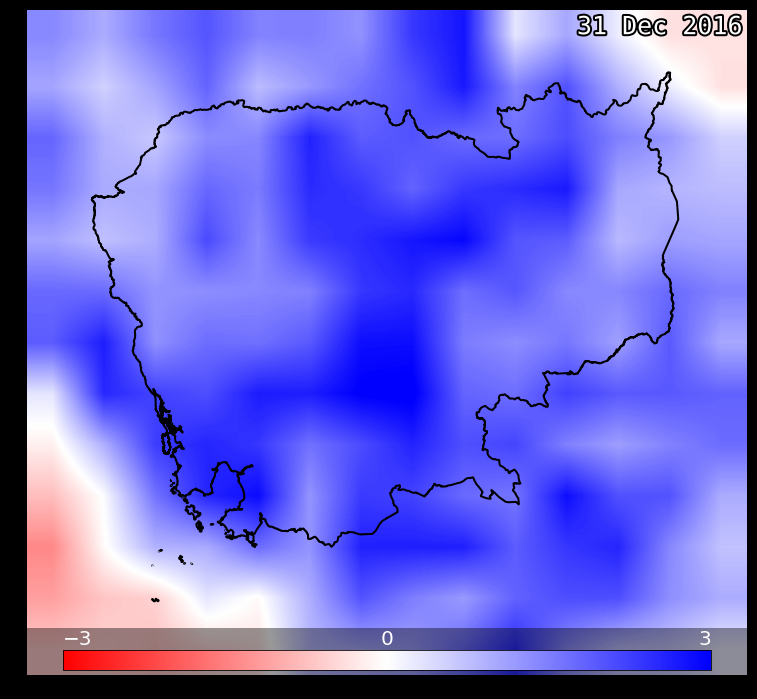

In [75]:
# shapefile_overlay = gpd.read_file("/g/data/u46/users/ext547/ewater/input_data/Cambodia_boundary/KHM_adm0.shp")

# fig, ax1 = plt.subplots(figsize=(13,5))

# # # Initialise axesimage objects to be updated during animation
# left, right, bottom, top = extent_
# im = ax1.imshow(cambodia_spei_12_unmasked.spei_gamma_12.isel(time=11).values, extent=[left, right, bottom, top])    


# # Add shapefile overlay
# shapefile_overlay.plot(ax = ax1, linewidth=2, edgecolor='black', facecolor="#00000000")

# Initialise annotation objects to be updated during animation
# t = ax1.annotate('', **annotation_kwargs)
        
# # Optionally add colourbar for one band images
# if (len(bands) == 1) & onebandplot_cbar:                
#     _add_colourbar(ax1, im, fontsize=20,
#                     vmin=onebandplot_kwargs['vmin'], 
#                     vmax=onebandplot_kwargs['vmax'])
cambodia_spei_03_xy = cambodia_spei_03.rename({'latitude':'y', 'longitude': 'x'})
    
animated_timeseries(ds = cambodia_spei_03_xy, output_path='/g/data/u46/users/sc0554/climate_indices_output/spei_03.gif', 
                                bands = ['spei_gamma_03'], show_date= True, onebandplot_cbar=True, onebandplot_kwargs={
                                    'cmap':'bwr_r', 'vmin':-3, 'vmax':3}, interval=250)

# plt.show()


In [ ]:
DEAPlotting.animated_doubletimeseries(ds1 = cambodia_spei_03_xy, ds2= monthly_environmental_data['rainfall'], output_path='/g/data/u46/users/sc0554/climate_indices_output/testdouble.gif', 
                                bands1 = ['spei_gamma_03'], bands2 = ['rainfall'], title1="SPEI", title2='Rainfall', onebandplot_kwargs1={
                                    'cmap':'bwr_r', 'vmin':-3, 'vmax':3}, onebandplot_kwargs2={'cmap':'bwr_r'}, interval=350)

In [ ]:
DEAPlotting.animated_doubletimeseries(ds1 = cambodia_spei_03, ds2= cambodia_spei_12, output_path='/g/data/u46/users/sc0554/climate_indices_output/spei_03_12_compare.gif', 
                                bands1 = ['spei_gamma_03'], bands2 = ['spei_gamma_12'], title1="SPEI_03", title2='SPEI_12', onebandplot_kwargs1={
                                    'cmap':'bwr_r', 'vmin':-3, 'vmax':3}, onebandplot_kwargs2={'cmap':'bwr_r', 'vmin':-3, 'vmax':3}, interval=350)

In [ ]:
#cambodia_spei_monthly.to_netcdf(path = '/g/data/u46/users/sc0554/climate_indices_output/cambodia_monthly_spei_gamma_03_transform.nc', format = 'NETCDF4')